# 2023-02-01 Convergence classes

* Office hours: Monday 9-10pm, Tuesday 2-3pm, Thursday 2-3pm
* This week will stay virtual. Plan is to start in-person the following Monday (Jan 31)

## Last time

* Forward and backward error
* Computing volume of a polygon
* Rootfinding examples
* Use [Roots.jl](https://juliapackages.com/p/roots) to solve
* Introduce Bisection

## Today

* Discuss rootfinding as a modeling tool
* Limitations of bisection
* Convergence classes
* Intro to Newton

In [1]:
using Plots
default(linewidth=4)

# Rootfinding

> Given $f(x)$, find $x$ such that $f(x) = 0$.

We'll work with scalars ($f$ and $x$ are just numbers) for now, and revisit later when they vector-valued.



# Iterative bisection

In [1]:
f(x) = cos(x) - x
hasroot(f, a, b) = f(a) * f(b) < 0
function bisect_iter(f, a, b, tol)
    hist = Float64[]
    while abs(b - a) > tol
        mid = (a + b) / 2
        push!(hist, mid)
        if hasroot(f, a, mid)
            b = mid
        else
            a = mid
        end
    end
    hist
end

bisect_iter (generic function with 1 method)

In [17]:
hist = bisect_iter(f, -1, 3, 1e-15)

52-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 ⋮
 0.7390851332147577
 0.7390851332156672
 0.7390851332152124
 0.739085133214985
 0.7390851332150987
 0.7390851332151556
 0.739085133215184
 0.7390851332151698
 0.7390851332151627
 0.7390851332151591
 0.7390851332151609
 0.73908513321516

# Let's plot the error

$$ \lvert \texttt{bisect}^k(f, a, b) - r \rvert, \quad k = 1, 2, \dotsc $$

where $r$ is the true root, $f(r) = 0$.

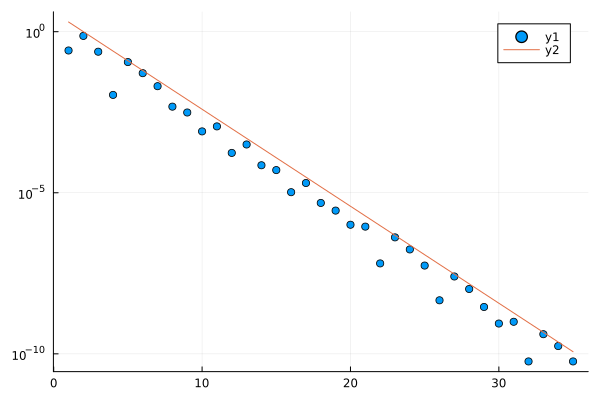

In [9]:
hist = bisect_iter(f, -1, 3, 1e-10)
r = hist[end] # What are we trusting?
hist = hist[1:end-1]
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
plot!(ks, 4 * (.5 .^ ks)) 

Evidently the error $e_k = x_k - x_*$ after $k$ bisections satisfies the bound
$$ |e^k| \le c 2^{-k} . $$

# Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that $$\lim_{k \to \infty} x_k \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{k \to \infty} |e_{k+1}| / |e_k| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_k| \le \epsilon_k $$
for all sufficiently large $k$ when the sequence $\{\epsilon_k\}$ converges $q$-linearly to 0.

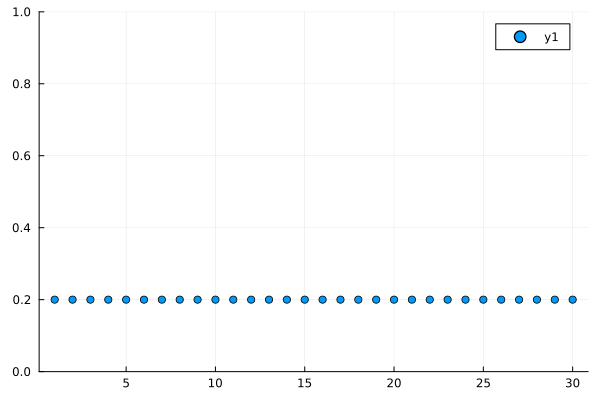

In [12]:
ρ = 0.2
errors = [1.]
for i in 1:30
    next_e = errors[end] * ρ
    push!(errors, next_e)
end
#plot(errors, yscale=:log10, ylims=(1e-10, 1))
e = hist .- r
scatter(abs.(errors[2:end] ./ errors[1:end-1]), ylims=(0,1))

## Bisection: A = q-linearly convergent, B = r-linearly convergent, C = neither

# Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* If bisection works for $f(x)$, then it works and gives the same accuracy for $f(x) \sigma(x)$ where $\sigma(x) > 0$.
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy

# Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [34]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end

f(x) = cos(x) - x
fp(x) = -sin(x) - 1
newton(f, fp, 1)

(0.739085133385284, -2.847205804457076e-10, 4)

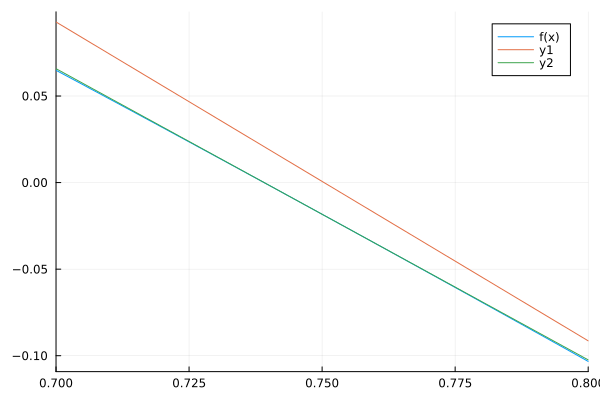

In [24]:
plot([f, x-> fp(1.)*(x-1.) + f(1.), x-> fp(0.7503638678402439)*(x-0.7503638678402439) + f(0.7503638678402439)],
    label = ["f(x)" "y1" "y2"], lw=1, xlims=(0.7, 0.8))

# That's really fast!

* 10 digits of accuracy in 4 iterations.
* How is this convergence test different from the one we used for bisection?
* How can this break down?

$$ x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)} $$

In [30]:
newton(f, fp, -pi/2 + 0.1; verbose=true)

[1] x=-1.4707963267948965  f(x)=1.5706297434417247  f'(x)=-0.0049958347219742905
[2] x=312.9170549232224  f(x)=-312.59435002533314  f'(x)=-0.05350037037604283
[3] x=-5529.927542752894  f(x)=5530.676391917825  f'(x)=-0.33725953180603474
[4] x=10868.945936970244  f(x)=-10868.376227850798  f'(x)=-0.17815359146505727
[5] x=-50136.70732252356  f(x)=50135.70777741902  f'(x)=-1.0301593101044748
[6] x=-1468.7903453577164  f(x)=1468.8859787856973  f'(x)=-1.9954166200403913
[7] x=-732.6603742863299  f(x)=731.8761094362295  f'(x)=-1.6204261800544972
[8] x=-281.0038172368656  f(x)=280.8358913898124  f'(x)=-1.9857996296872256
[9] x=-139.58174866993488  f(x)=139.79912372811944  f'(x)=-0.02391184615360531
[10] x=5706.856156210999  f(x)=-5707.008659764705  f'(x)=-1.9883029222393844
[11] x=2836.5648158265976  f(x)=-2837.5220962814674  f'(x)=-1.2891610809292957
[12] x=635.503879177757  f(x)=-634.8839651181479  f'(x)=-1.784669713127157
[13] x=279.7607629875442  f(x)=-280.7481464325292  f'(x)=-0.841652494

(0.7390851332151608, -2.220446049250313e-16, 24)

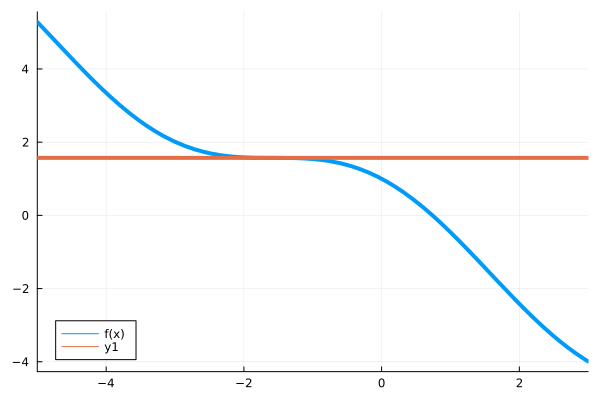

In [52]:
plot([f, x-> fp(-pi/2)*(x+pi/2) + f(-pi/2)],
label = ["f(x)" "y1"], legend=:bottomleft, xlims=(-5, 3))

# Plotting Newton convergence

In [31]:
function newton_hist(f, fp, x0; tol=1e-12)
    x = x0
    hist = []
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        push!(hist, [x fx fpx])
        if abs(fx) < tol
            return vcat(hist...)
        end
        x = x - fx / fpx
    end
end

newton_hist (generic function with 1 method)

x_star = xs[end, 1] = 0.7390851332151607


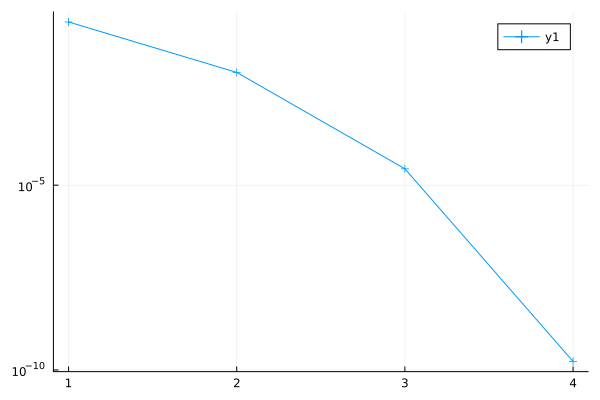

In [32]:
xs = newton_hist(f, fp, 1)
@show x_star = xs[end,1]
plot(xs[1:end-1,1] .- x_star, yscale=:log10, marker=:auto)

# Quadratic convergence!
* It turns out that Newton's method has _locally quadratic_ convergence to simple roots,
$$\lim_{k \to \infty} \frac{|e_{k+1}|}{|e_k|^2} < \infty.$$
* "The number of correct digits doubles each iteration."
* Now that we know how to make a good guess accurate, the effort lies in getting a good guess.